# **Imports**

In [26]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functionsML as f
from itertools import combinations
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler

# data partition
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import importlib
importlib.reload(f)

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy.stats as stats

### **Import data sets**

In [13]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

The first thing we do is split the data, so we can prevent any sort of leakage from happening

In [14]:
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=2, shuffle=True)

# **Data exploration**

Our goal here is to understand the data, and the possible issues that come with it

In [181]:
train_set.head(15)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
11446,35675,Mercedes,NaN,2016.0,37385,Automatic,21169.0,Diesel,305.0,37.2,3.0,42.0,3.0,0.0
42107,72523,VW,Passat,2016.0,8000,Manual,101370.0,Diesel,20.0,70.6,1.6,81.0,3.0,0.0
42568,26747,Ford,Fiesta,2015.0,6700,Manual,41406.0,Petrol,125.0,54.3,1.2,85.0,4.0,0.0
56466,44023,NaN,GLE Class,2019.0,47390,Semi-Auto,9500.0,Diesel,145.0,36.7,2.0,35.0,0.0,0.0
41646,73041,VW,Golf,2016.0,20990,Semi-Auto,28406.0,Petrol,205.0,39.8,2.0,84.0,1.0,0.0
37445,3113,Audi,A1,2019.0,21445,Semi-Auto,5844.0,Petrol,150.0,40.4,2.0,73.0,4.0,0.0
71382,46250,Mercede,C Class,2014.0,16964,Automatic,20281.0,Diesel,NaN,NaN,2.1,94.0,3.0,0.0
75713,54045,Toyota,Aygo,2017.0,6995,Manual,8932.0,NaN,145.0,69.0,1.0,76.0,0.0,0.0
66927,55032,Toyota,Auris,2017.0,10698,Manual,NaN,diesel,150.0,67.3,1.6,71.0,1.0,0.0
60696,64930,Opel,Astra,2017.0,10530,Manual,21845.0,Diesel,0.0,83.1,1.6,51.0,1.0,0.0


- Typos in transmission and fuel

- EngineSize with NaN

- Mileage, mpg and previousOwners with irational values

- PreviousOwners with negative values

- hasDamage seems to always be 0

In [182]:
train_set.describe(include='object')

,Brand,model,transmission,fuelType
count,52096,52125,52133,52109
unique,69,682,39,34
top,Ford,Focus,Manual,Petrol
freq,10375,4469,26733,26642


- The categorical variables have a lot of unique values

In [183]:
train_set.describe()

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,53181.000000,52150.000000,53181.000000,52136.000000,47626.000000,47602.000000,52123.000000,52136.000000,52088.000000,52101.0
mean,38022.666009,2017.102655,16867.168820,23010.701255,120.376201,55.111169,1.658290,64.520649,1.989224,0.0
std,21915.140171,2.213196,9756.826483,22158.932549,65.410970,16.246049,0.572962,21.005830,1.471792,0.0
min,0.000000,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,19051.000000,2016.000000,10199.000000,7416.500000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,38031.000000,2017.000000,14690.000000,17270.500000,145.000000,54.300000,1.600000,64.000000,2.000000,0.0
75%,56979.000000,2019.000000,20900.000000,32428.000000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,75972.000000,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


- Missing values in year mileage tax mpg engineSize paintQuality% previousOwners and hasDamage

- Alarming min values in mileage tax mpg engineSize paintQuality% previousOwners

- Alarming max values in year mpg paintQuality% previousOwners

- HasDamage is always 0

In [184]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 11446 to 72173
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           53181 non-null  int64  
 1   Brand           52096 non-null  object 
 2   model           52125 non-null  object 
 3   year            52150 non-null  float64
 4   price           53181 non-null  int64  
 5   transmission    52133 non-null  object 
 6   mileage         52136 non-null  float64
 7   fuelType        52109 non-null  object 
 8   tax             47626 non-null  float64
 9   mpg             47602 non-null  float64
 10  engineSize      52123 non-null  float64
 11  paintQuality%   52136 non-null  float64
 12  previousOwners  52088 non-null  float64
 13  hasDamage       52101 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 6.1+ MB


- Year is float64, should be int64

- PreviousOwners is float, should be int64

In [185]:
f.missing_values_table(train_set)

Total columns: 14
Columns with missing values: 12



,Missing Values,Percent Missing (%)
mpg,5579,10.49
tax,5555,10.45
previousOwners,1093,2.06
Brand,1085,2.04
hasDamage,1080,2.03
fuelType,1072,2.02
model,1056,1.99
engineSize,1058,1.99
transmission,1048,1.97
mileage,1045,1.96


In [186]:
f.negative_values_table(train_set)
# In this context negative numbers don't make sense

Total numeric columns: 10
Columns with negative values: 5



,Negative Values,Percent Negative (%)
tax,274,0.52
previousOwners,262,0.49
mileage,247,0.46
engineSize,60,0.11
mpg,29,0.05


In [187]:
f.irrational_values_table(train_set)
# Realistically none of the numerical variables should have entries with more than 1-2 decimals

Total numeric columns: 10
Columns with irrational values: 7
Rows with at least one irrational value: 3564



,Irrational Count,Percent Irrational (%)
engineSize,552,1.04
tax,535,1.01
mpg,525,0.99
year,522,0.98
mileage,511,0.96
previousOwners,510,0.96
paintQuality%,495,0.93
Total (rows with any irrational value),3564,6.70


# **Unique Values**

We wanted to take a better look at what kind of values each variable had, and we ended up finding:

- Typos in every categorical variable

- Different letter casing in every categorical variable

- Unrealistic negative values and irrational values in every numerical category

In [188]:
# Loop through each column in the DataFrame
for column in train_set.columns:

    # Print unique values and count for columns with fewer than 20 unique values
    print(f"Unique values in '{column}': {train_set[column].unique()}")
    print(f"Number of unique values: {train_set[column].nunique()}\n")


Unique values in 'carID': [35675 72523 26747 ...  2624 65485 75219]
Number of unique values: 53181

Unique values in 'Brand': ['Mercedes' 'VW' 'Ford' nan 'Audi' 'Mercede' 'Toyota' 'Opel' 'Skoda'
 'Hyundai' 'BMW' 'For' 'audi' 'ord' 'mercedes' 'V' 'MW' 'W' 'SKODA' 'ford'
 'HYUNDAI' 'ercedes' 'AUDI' 'FORD' 'OPEL' 'pel' 'Hyunda' 'opel' 'vw' 'mw'
 'udi' 'MERCEDES' 'Aud' 'ORD' 'Ope' 'TOYOTA' 'skoda' 'bmw' 'oyota' 'BM'
 'yundai' 'koda' 'hyundai' 'for' 'pe' 'Toyot' 'Skod' 'toyota' 'v' 'HYUNDA'
 'w' 'ope' 'ercede' 'ERCEDES' 'OPE' 'yunda' 'aud' 'or' 'ud' 'kod'
 'MERCEDE' 'OYOTA' 'AUD' 'FOR' 'PEL' 'hyunda' 'mercede' 'toyot' 'UDI'
 'skod']
Number of unique values: 69

Unique values in 'model': [nan ' Passat' ' Fiesta' ' GLE Class' ' Golf' ' A1' ' C Class' ' Aygo'
 ' Auris' ' Astra' ' Focus' ' Polo' ' Citigo' ' I10' ' EcoSport'
 ' 3 Series' ' CROSSLAND X' ' focus' ' A3' ' Q3' ' Scirocco' ' Galaxy'
 ' Kuga' ' Q5' ' X2' ' KA' ' 4 Series' ' Fabia' ' Up' ' Ka+' ' Arteon'
 ' Insignia' ' YARIS' ' Viva' '

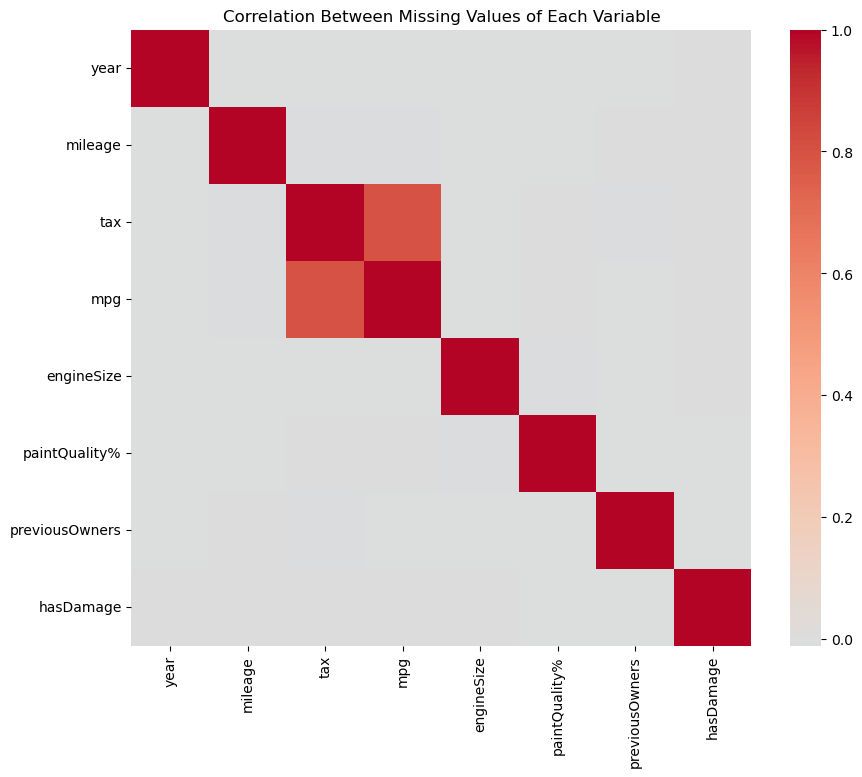

In [8]:

missing_mask = train_set.drop(columns=["carID", "price"], errors="ignore").select_dtypes(include=["number"]).isna()

missing_corr = missing_mask.corr(method="spearman")

# Plot the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(missing_corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Between Missing Values of Each Variable")
plt.show()

- There is a strong correlation between mpg's and tax's missing values

# **Distributions & Value Counts**

In [190]:
train_set["Brand"].value_counts()

Brand
Ford        10375
Mercedes     7545
VW           6842
Opel         6039
BMW          4838
            ...  
mercede         2
PEL             1
AUD             1
toyot           1
skod            1
Name: count, Length: 69, dtype: int64

In [191]:
train_set["model"].value_counts()

model
 Focus             4469
 C Class           3407
 Fiesta            2890
 Golf              2147
 Corsa             1518
                   ... 
GTC                   1
 tourneo custom       1
Scala                 1
Toura                 1
yaris                 1
Name: count, Length: 682, dtype: int64

- Some entries also have space characters

In [192]:
train_set["transmission"].value_counts()

transmission
Manual       26733
Semi-Auto    10890
Automatic     9753
anual          571
MANUAL         560
manual         534
Manua          525
unknown        489
 Manual        248
semi-auto      232
utomatic       224
Semi-Aut       220
emi-Auto       211
AUTOMATIC      206
SEMI-AUTO      204
Automati       202
automatic      196
unknow          15
UNKNOWN         10
anua            10
ANUAL           10
Manual           9
SEMI-AUT         9
MANUA            9
EMI-AUTO         7
emi-auto         7
utomati          6
 manual          5
AUTOMATI         5
 Manual          5
 MANUAL          5
nknown           5
semi-aut         4
automati         4
Other            3
emi-Aut          3
manua            2
manual           1
UTOMATIC         1
Name: count, dtype: int64

In [193]:
train_set["fuelType"].value_counts()

fuelType
Petrol      26642
Diesel      19918
Hybrid       1420
etrol         553
Petro         547
PETROL        532
petrol        504
iesel         427
diesel        418
Diese         418
DIESEL        405
Other         103
HYBRID         39
hybrid         36
Hybri          26
ybrid          24
etro           13
PETRO          12
petro          10
IESEL          10
ETROL          10
iese            8
DIESE           7
ther            5
diese           5
Othe            3
Electric        3
HYBRI           2
YBRID           2
other           2
OTHER           2
ETRO            1
IESE            1
ybri            1
Name: count, dtype: int64

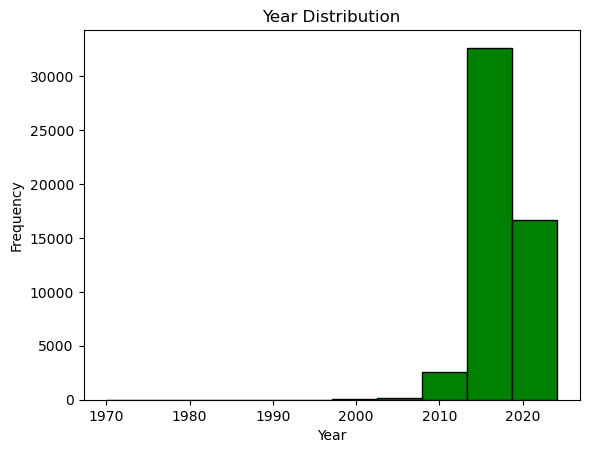

In [194]:
# Plot histogram for the "year" column
f.plot_histogram(train_set["year"], 
                 "Year",         # x-axis label
                 "Frequency",   # y-axis label
                 "Year Distribution")  # title of the plot

- The distribuition is very right side heavy, with only a few entries before the year 2000

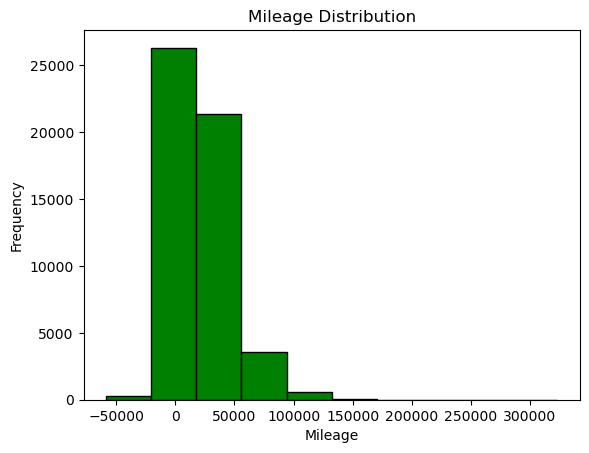

In [195]:
# Plot histogram for the "mileage" column
f.plot_histogram(train_set["mileage"], 
                 "Mileage",         # x-axis label
                 "Frequency",   # y-axis label
                 "Mileage Distribution")  # title of the plot

- There are some entries with negative mileage

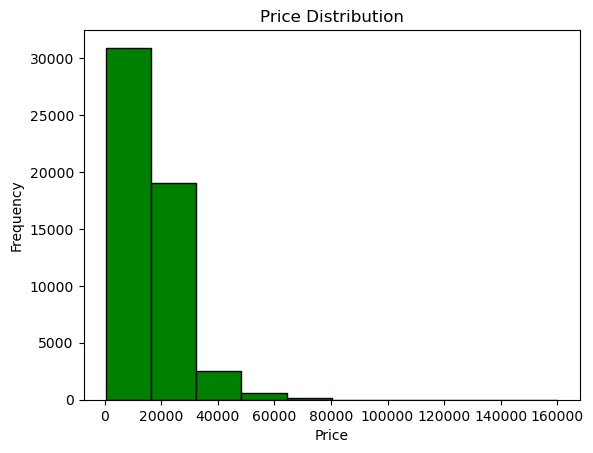

In [196]:
# Plot histogram for the "price" column
f.plot_histogram(train_set["price"], 
                 "Price",         # x-axis label
                 "Frequency",   # y-axis label
                 "Price Distribution")  # title of the plot

- The distribuition is very heavy on the lower end of prices

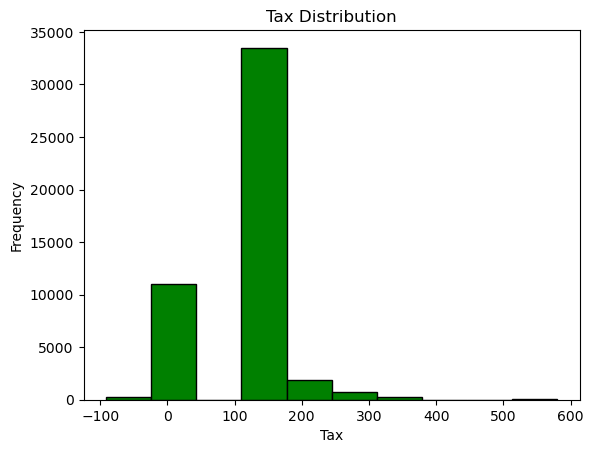

In [197]:
# Plot histogram for the "tax" column
f.plot_histogram(train_set["tax"], 
                 "Tax",         # x-axis label
                 "Frequency",   # y-axis label
                 "Tax Distribution")  # title of the ploty

- There are negative tax values and there is a gap between entries with 0 tax and 100

- The majirity of the entries are between 100 and 200 dollars

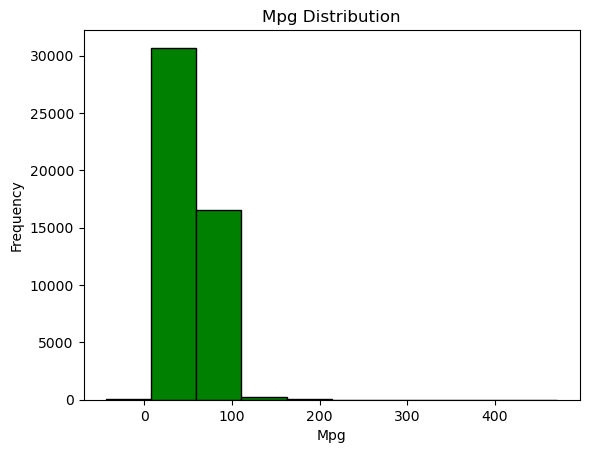

In [198]:
# Plot histogram for the "mpg" column
f.plot_histogram(train_set["mpg"], 
                 "Mpg",         # x-axis label
                 "Frequency",   # y-axis label
                 "Mpg Distribution")  # title of the ploty

- There are a few negative values and values over 100

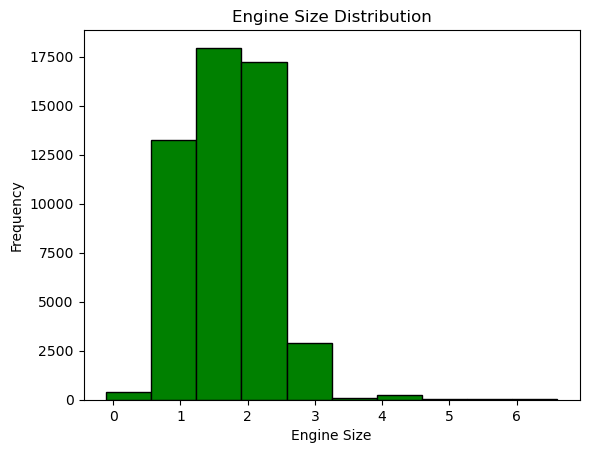

In [199]:
# Plot histogram for the "engineSize" column
f.plot_histogram(train_set["engineSize"], 
                 "Engine Size",         # x-axis label
                 "Frequency",   # y-axis label
                 "Engine Size Distribution")  # title of the ploty

- Engine sizes at 0, and a few above 3

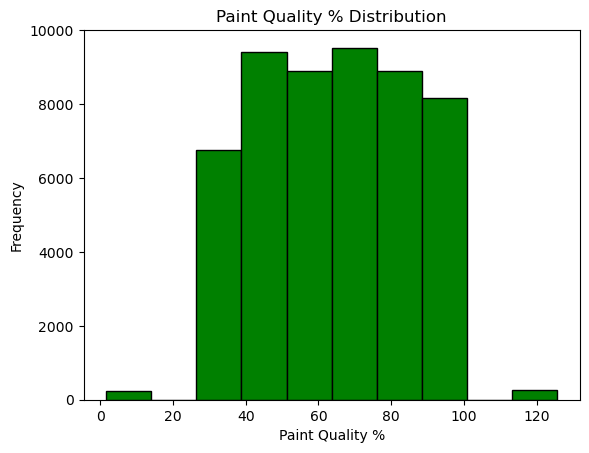

In [200]:
# Plot histogram for the "paintQuality%" column
f.plot_histogram(train_set["paintQuality%"], 
                 "Paint Quality %",         # x-axis label
                 "Frequency",   # y-axis label
                 "Paint Quality % Distribution")  # title of the ploty

- Paint quality entries above 100 dont make sense, since the variable is a percentage

- There is also a small chuck of entries close to 0

# **Fixing issues**

#### Here we aim to treat the spotted issues, outliers and NaN values

In [15]:
# - Drop irrelevant column -
# they can only be obtained by the mechanic, so they don't hold any relevancy to us
train_set = train_set.drop(columns=["hasDamage","paintQuality%"])

train_set_numerical = train_set.select_dtypes(exclude=["object"]).columns

# - Fixing text columns -
# there are a lot of typos and different casings in all of the text columns
text_cols = train_set.select_dtypes(include=["object"]).columns
train_set[text_cols] = train_set[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
for col in text_cols:
    train_set = f.fix_typos(col, train_set)




In [16]:
# - Drop irrelevant column -
# they can only be obtained by the mechanic, so they don't hold any relevancy to us
val_set = val_set.drop(columns=["hasDamage", "paintQuality%"])

val_set_numerical = val_set.select_dtypes(exclude=["object"]).columns


# - Fixing text columns -
# there are a lot of typos and different casings in all of the text columns
text_cols = val_set.select_dtypes(include=["object"]).columns
val_set[text_cols] = val_set[text_cols].apply(lambda x: x.str.lower() if x.dtype == "object" else x)
for col in text_cols:
    val_set = f.fix_typos(col, val_set)

### **Outlier treatment**

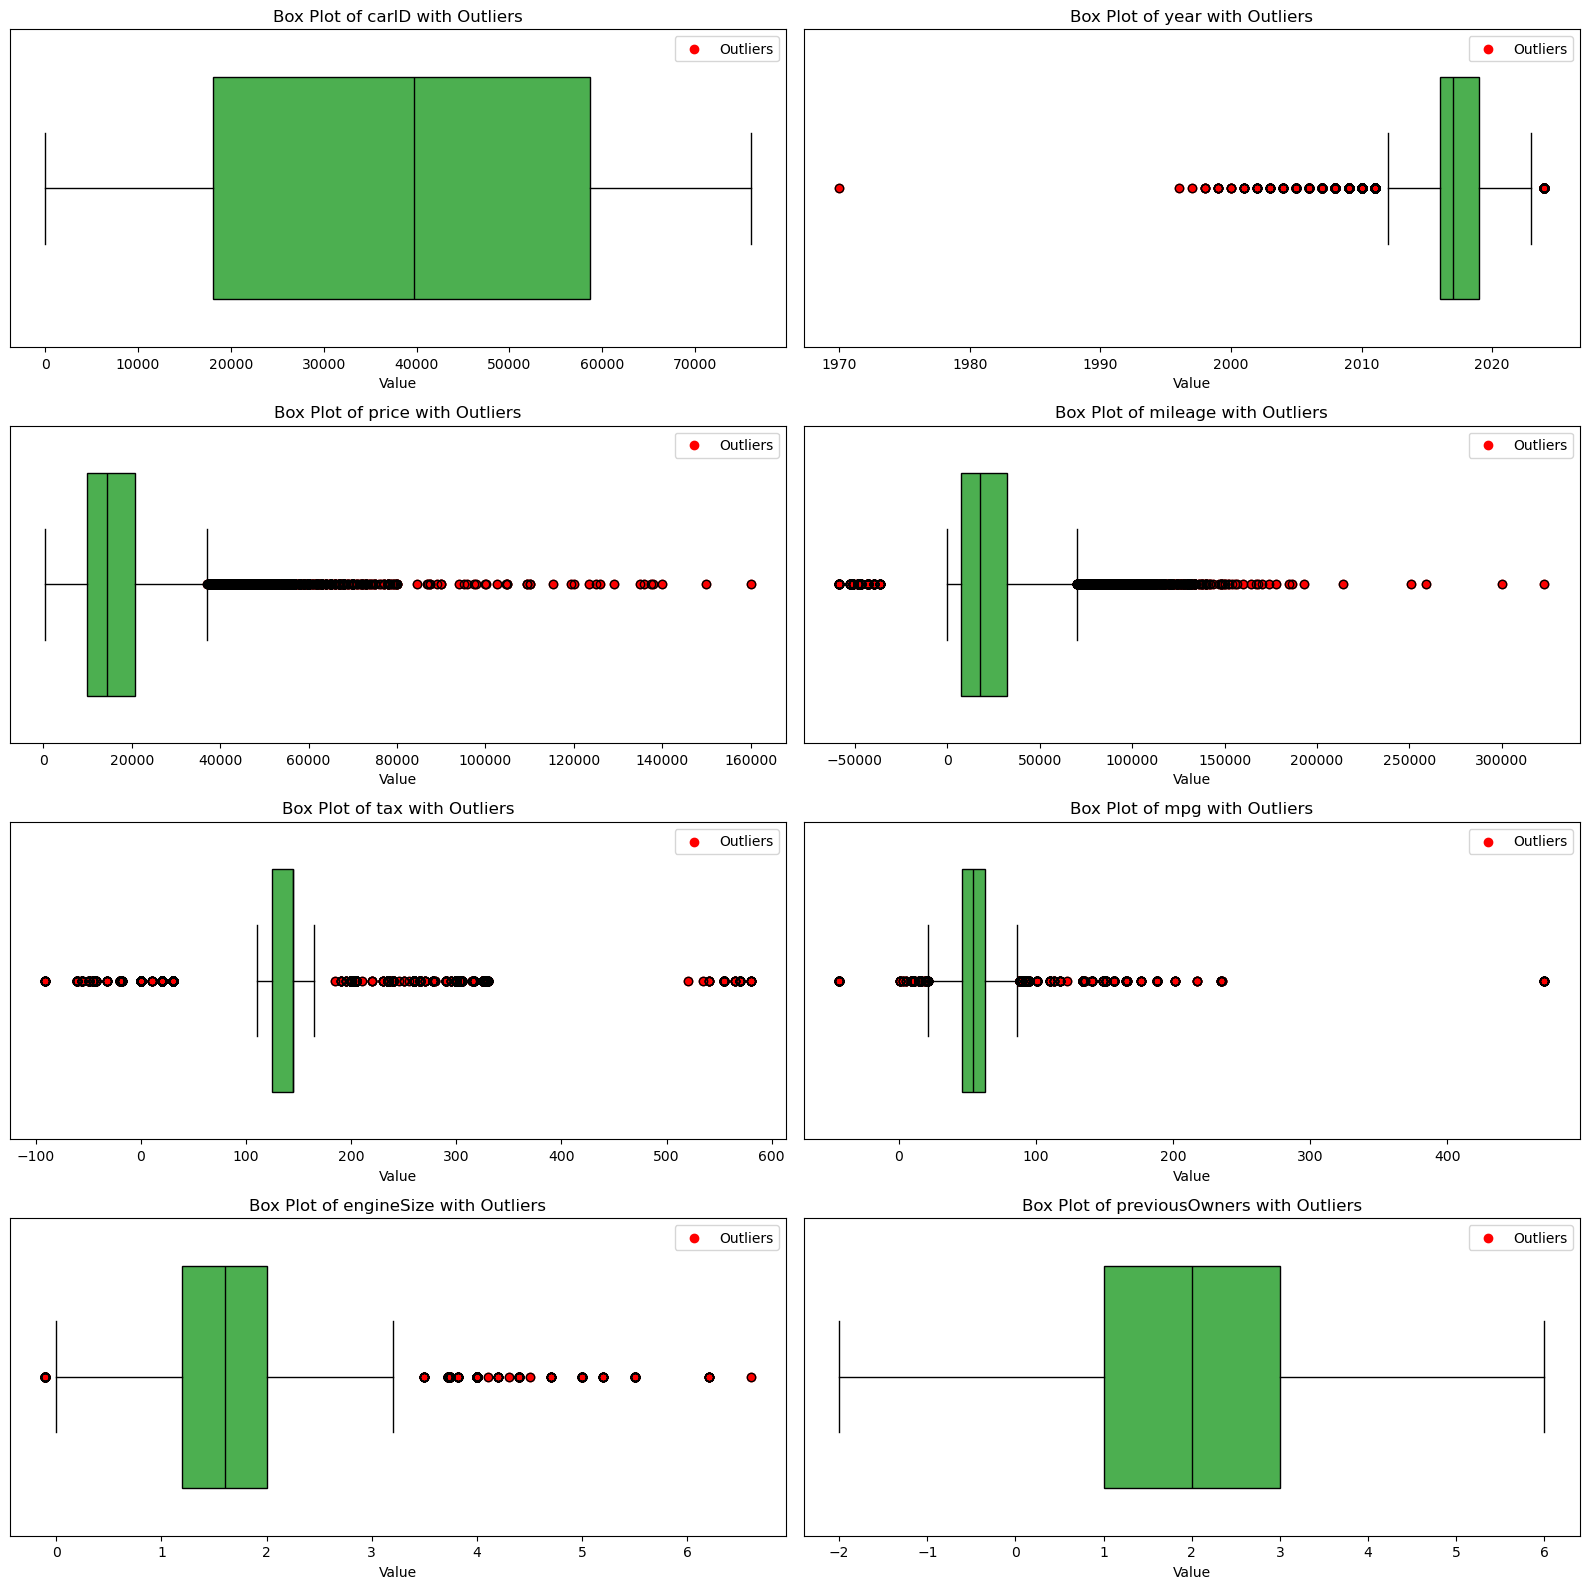

In [203]:
f.plot_multiple_boxes_with_outliers(train_set.dropna(), train_set_numerical)

- We can imideatly spot some issues on the graphs, including absurd values and values that don't make sense

##### We analyzed some variables using .value_counts() so we could better assess whether they contained significant entries or absurd/outlier values

In [204]:
year_below_1999 = train_set[train_set["year"] <= 1999]

# Display the filtered entries
year_below_1999["year"].value_counts()


year
1998    5
1999    5
1970    2
1997    1
1996    1
Name: count, dtype: Int64

In [205]:
preivousOwners_above_4 = train_set[train_set["previousOwners"] > 4]

# Display the filtered entries
preivousOwners_above_4["previousOwners"].value_counts()

previousOwners
6    248
Name: count, dtype: Int64

In [17]:
# Removed replace absurd/incorrect values with NaN for them later to be filled

# Negative mileage values indicate data entry errors or corrupted records. 
# These values do not represent real-world mileage and would distort model training.
train_set.loc[train_set["mileage"] < 0, "mileage"] = np.nan 

# Car road tax cannot be negative
train_set.loc[train_set["tax"] < 0, "tax"] = np.nan 

# Mpg cannot be negative.
# Values above 150 mpg are unrealistic for traditional cars
train_set.loc[~train_set["mpg"].between(0, 150), "mpg"] = np.nan

# No engineSize value below 1 seems to be realistic and hold any significance
# Above 6.3 there is a single entry that seems to be a mistake, given that we have a substantial amount of entries with the same Brand and model and they never surpass 4.4
train_set.loc[~train_set["engineSize"].between(1, 6.3), "engineSize"] = np.nan

# There are only 2 entries before 1990 and they have a huge age gap between the oldest car after 1990 (26 years), so we treat every entry with year below 1990 as an absurd value
# The data set only includes data from up to 2020
train_set.loc[~train_set["year"].between(1990, 2020), "year"] = np.nan

# Previous owners below 0 makes no sense
# All of the entries above 4 seem to make no sense as they are all float values for a column that realistically should only have natural numbers
train_set.loc[~train_set["previousOwners"].between(0, 4), "previousOwners"] = np.nan


In [18]:
# We do the exact same for the validation set
val_set.loc[val_set["mileage"] < 0, "mileage"] = np.nan 
val_set.loc[val_set["tax"] < 0, "tax"] = np.nan 
val_set.loc[~val_set["mpg"].between(0, 150), "mpg"] = np.nan
val_set.loc[~val_set["engineSize"].between(1, 6.3), "engineSize"] = np.nan
val_set.loc[~val_set["year"].between(1990, 2020), "year"] = np.nan
val_set.loc[~val_set["previousOwners"].between(0, 4), "previousOwners"] = np.nan


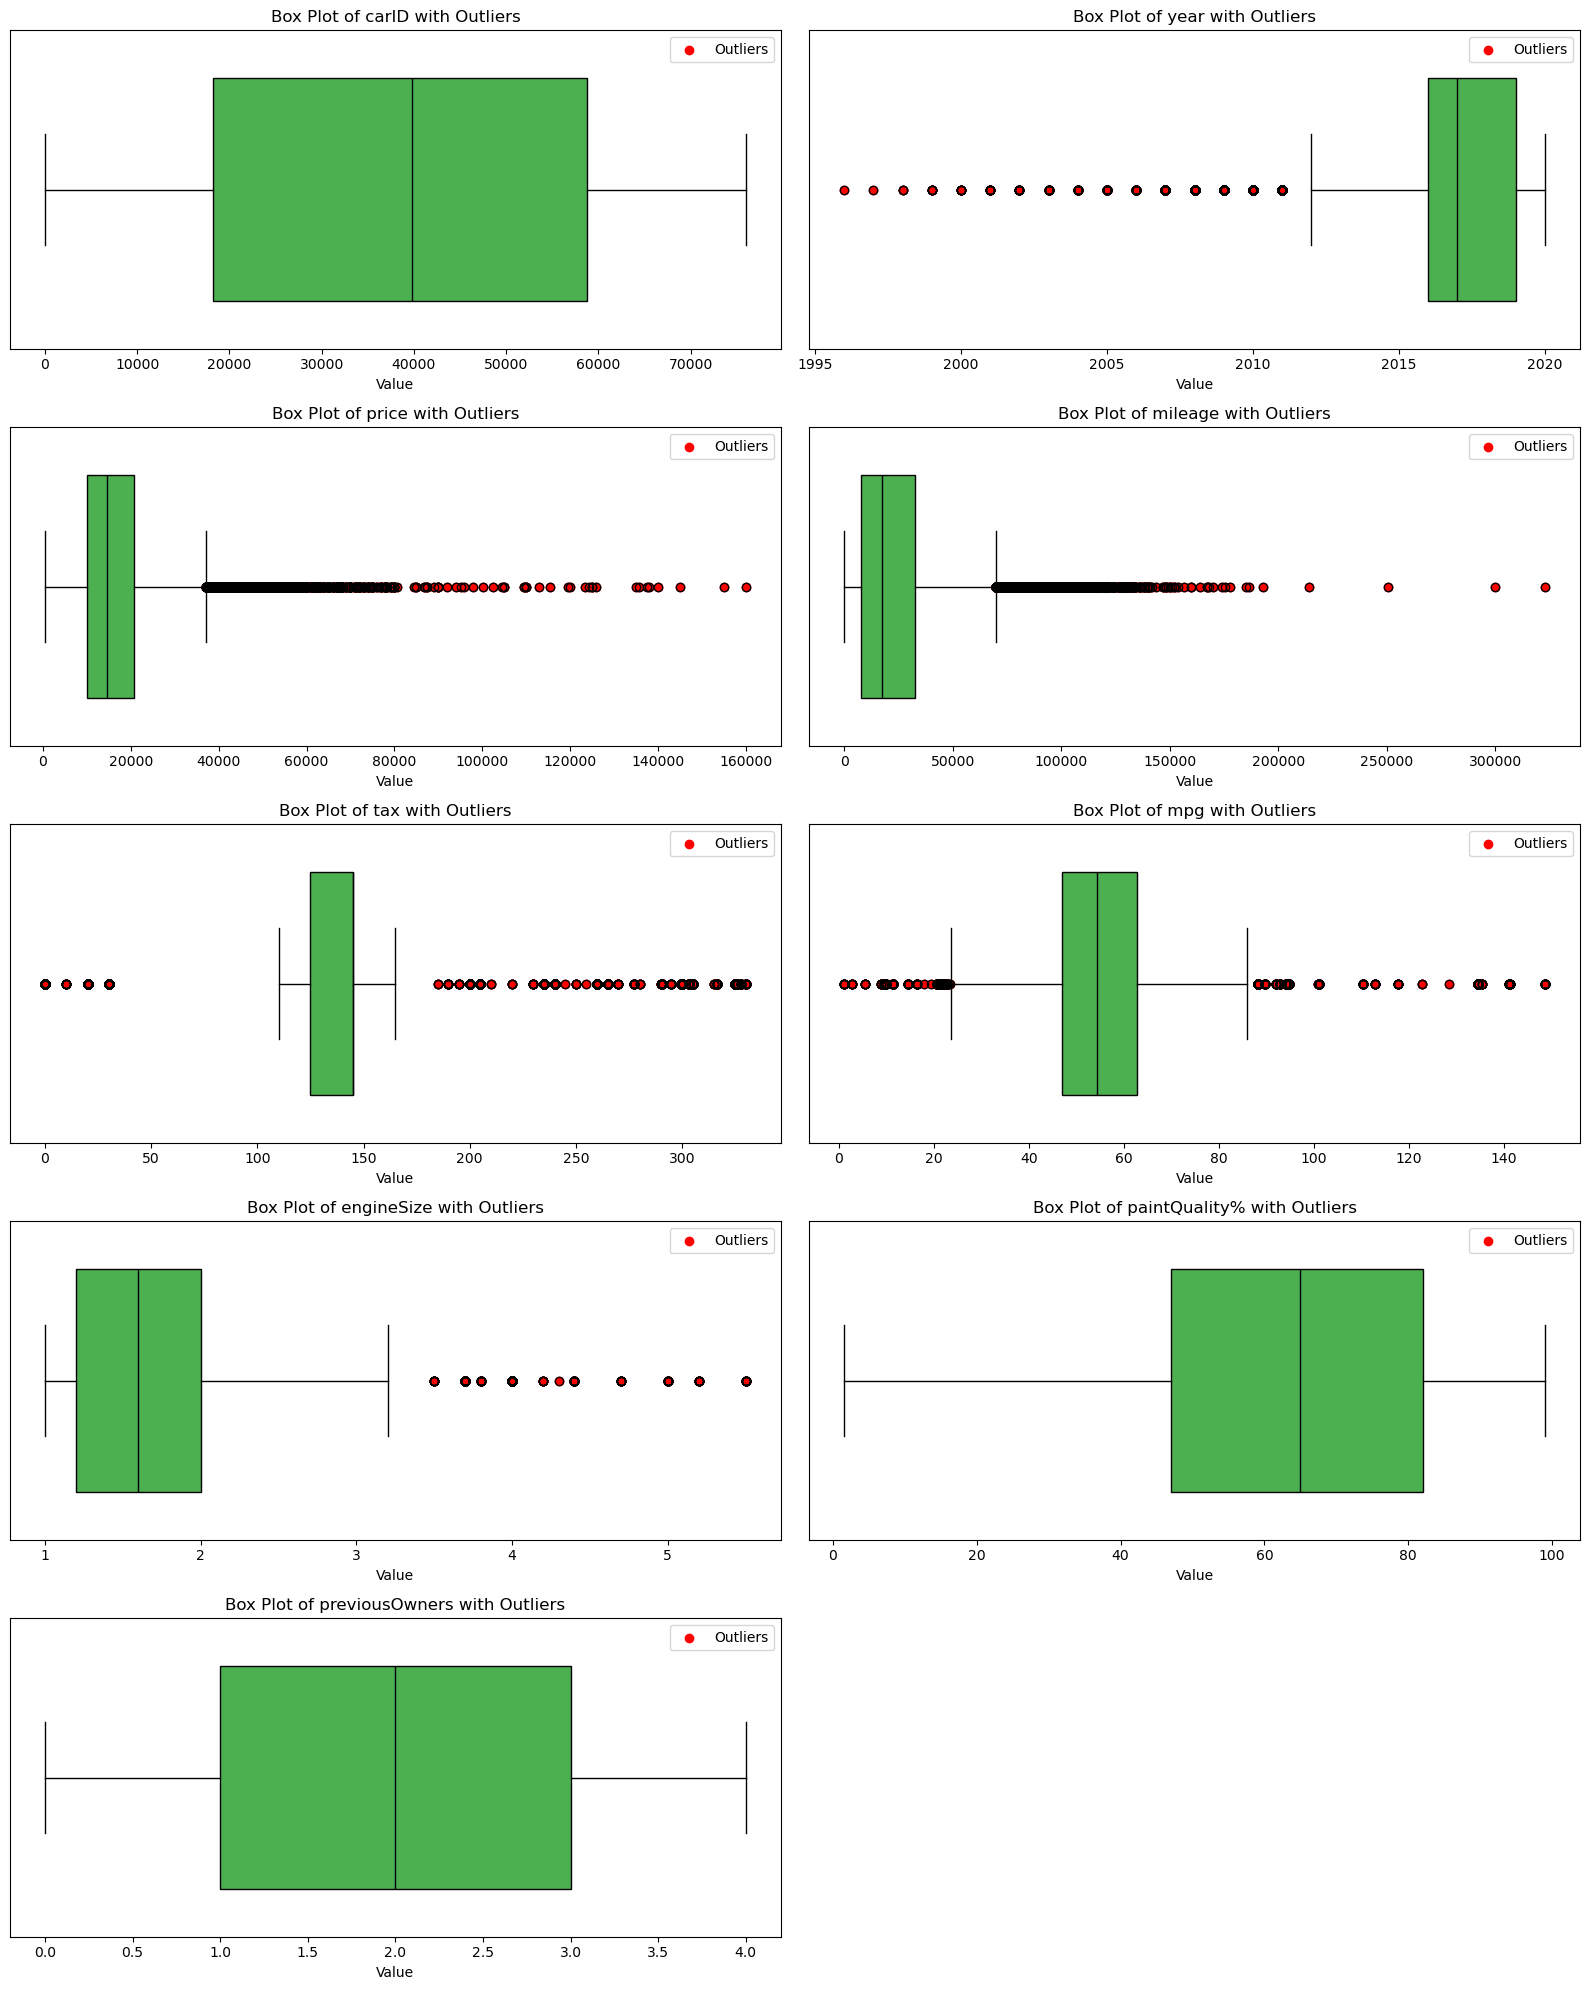

In [ ]:
f.plot_multiple_boxes_with_outliers(train_set.dropna(), train_set_numerical)

#### Next we apply log(1 + x) transformation to reduce skewness and normalize distribution
##### This will help our model handle certain right-skewed variables better

In [19]:
train_set['price'] = np.log1p(train_set['price'])
train_set['tax'] = np.log1p(train_set['tax'])
train_set['mileage'] = np.log1p(train_set['mileage'])
train_set['mpg'] = np.log1p(train_set['mpg'])

In [20]:
# We do the exact same for the validation set
val_set['price'] = np.log1p(val_set['price'])
val_set['tax'] = np.log1p(val_set['tax'])
val_set['mileage'] = np.log1p(val_set['mileage'])
val_set['mpg'] = np.log1p(val_set['mpg'])


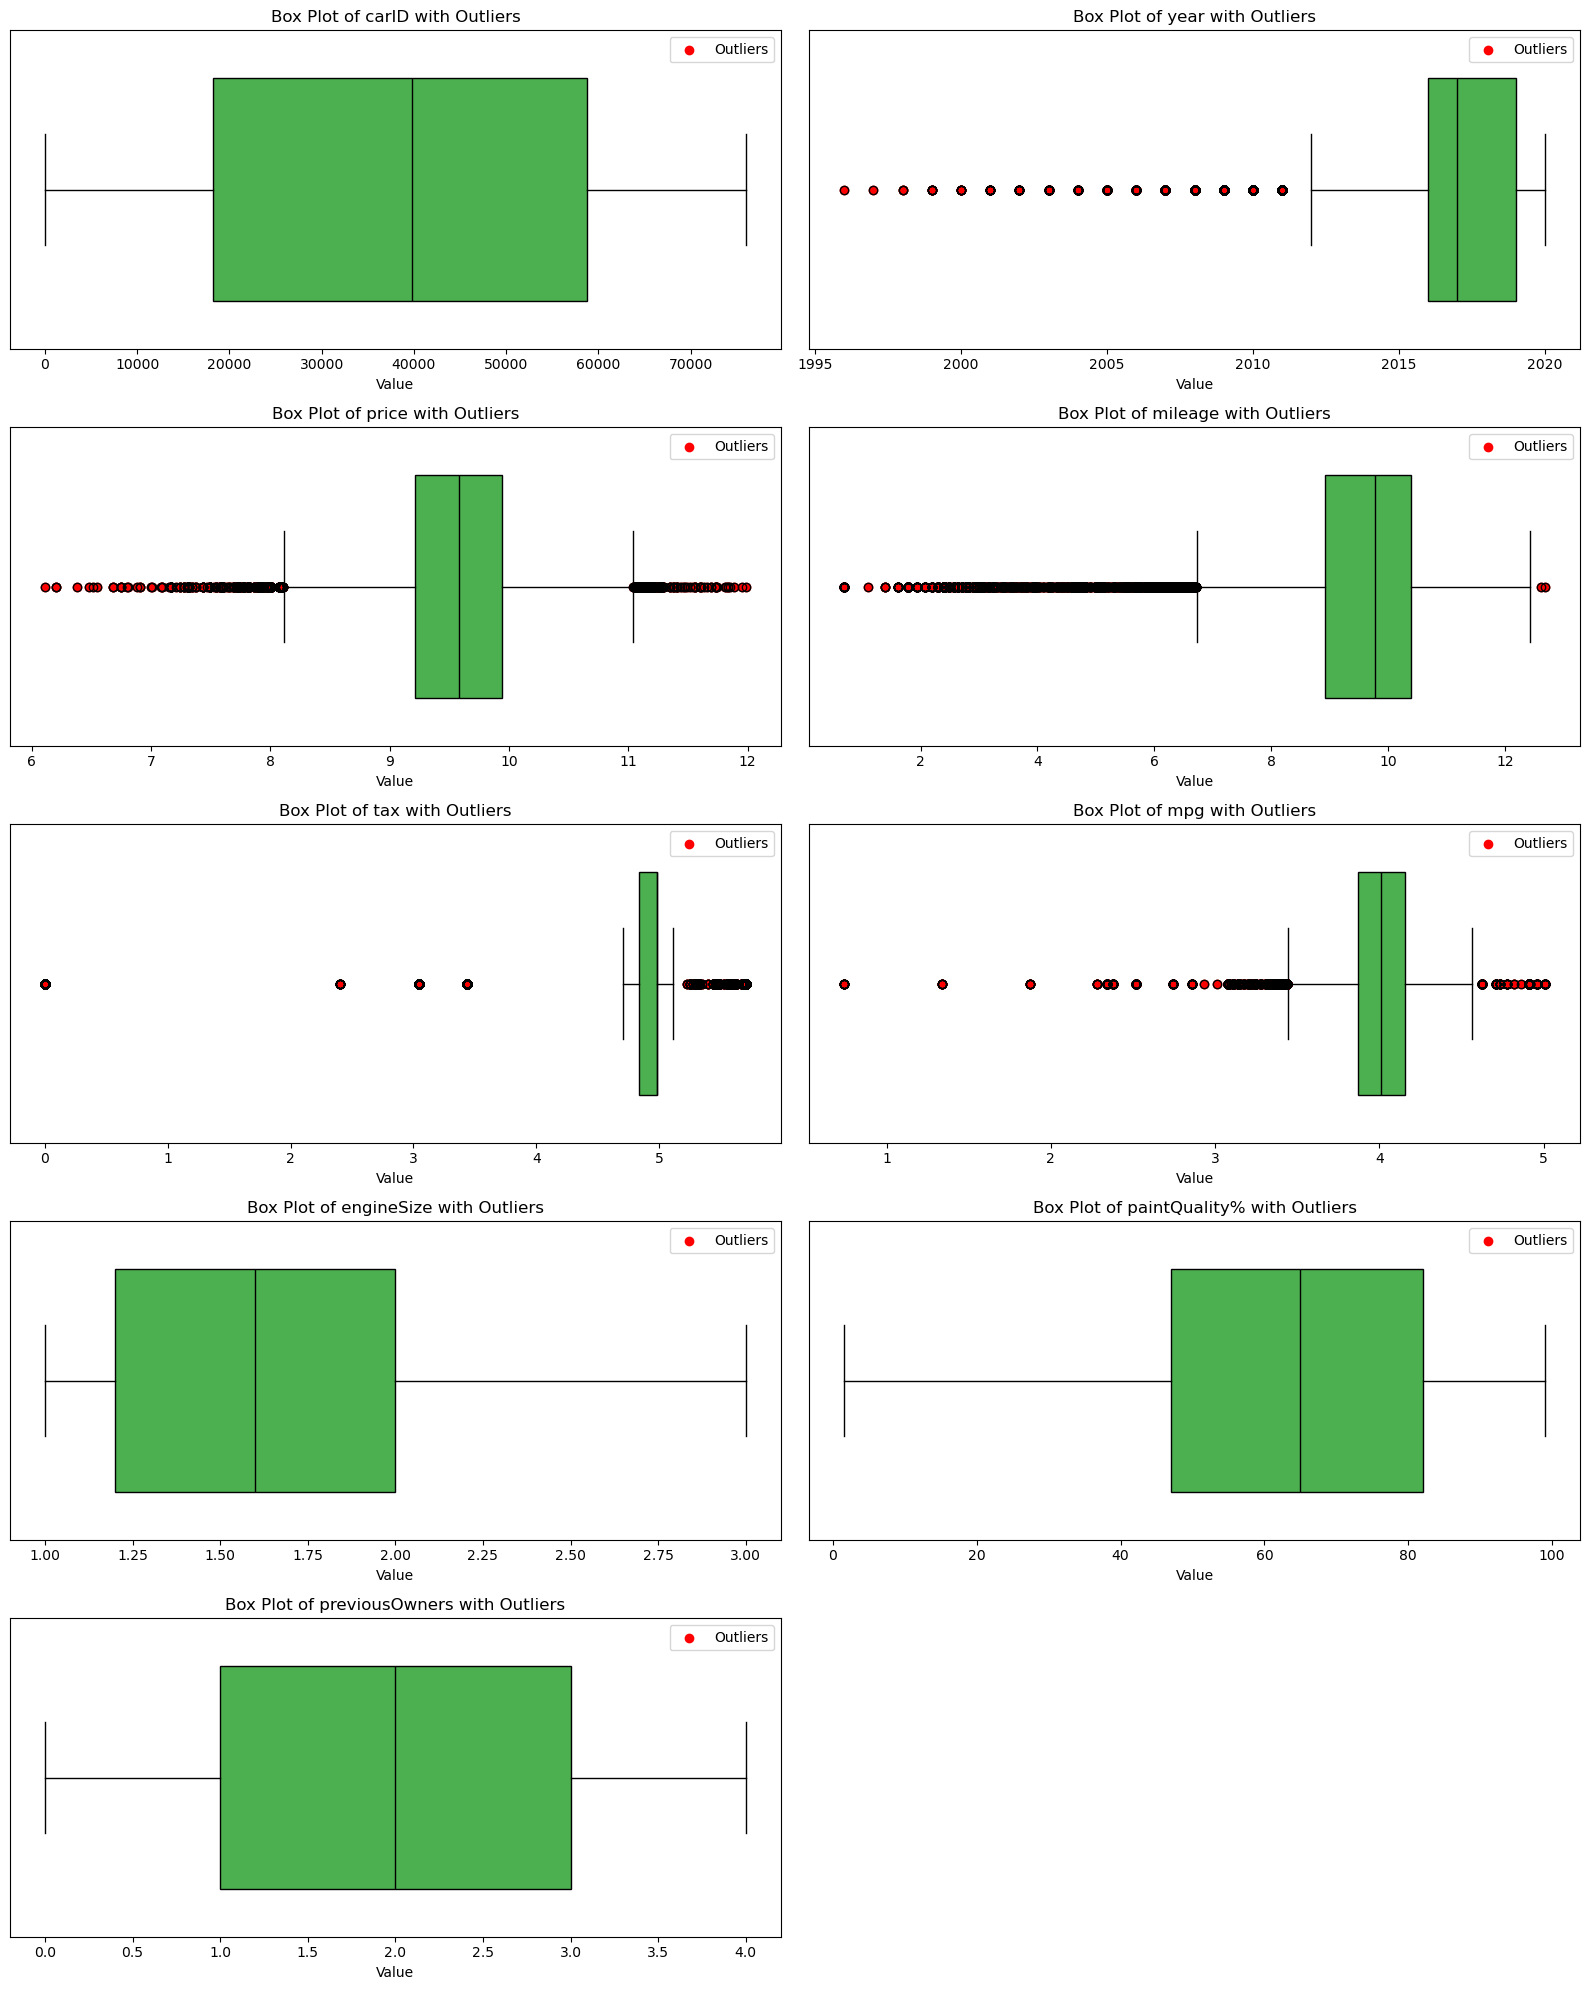

In [ ]:
f.plot_multiple_boxes_with_outliers(train_set.dropna(), train_set_numerical)

In [21]:
# We also need to round some values that should only have natural numbers

# - Types and Rounding -
# both previousOwners and year are categories that should only have natural numbers
train_set["previousOwners"] = pd.to_numeric(train_set["previousOwners"], errors='coerce').round().astype("Int64")
train_set["year"] = pd.to_numeric(train_set["year"], errors='coerce').round().astype("Int64")

# same goes for val_set
val_set["previousOwners"] = pd.to_numeric(val_set["previousOwners"], errors="coerce").round().astype("Int64")
val_set["year"] = pd.to_numeric(val_set["year"], errors="coerce").round().astype("Int64")

## **Variable Relationships**

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

So we ended up going with a Theil's U directional relationship, while also testing out different variable combinations

In [23]:
num_cols = train_set.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns
cat_cols = train_set.select_dtypes(include=['object']).columns

# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_set[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_set[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.563
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.520

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.330
  U(transmission | model + fuelType) = 0.319
  U(transmission | Brand + model) = 0.294

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.404
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [128]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
import pandas as pd

for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):  
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_set[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_combo in combinations(cat_cols, num_paired):
            combined = train_set[list(cat_combo)].astype(str).agg('_'.join, axis=1)
            scores[cat_combo] = f.correlation_ratio(combined, train_set[target]) ** 2

    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")


For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.559
 ('tax', 'model') => 0.499
 ('mileage', 'fuelType') => 0.472

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'model') => 0.465
 ('year', 'fuelType') => 0.430
 ('year', 'Brand') => 0.406

For numerical column 'tax', top helpers (R² or η²):
 ('year', 'model') => 0.482
 ('mpg', 'model') => 0.395
 ('mileage', 'model') => 0.357

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.562
 ('tax', 'model') => 0.523
 ('engineSize', 'fuelType') => 0.504

For numerical column 'engineSize', top helpers (R² or η²):
 ('tax', 'model') => 0.704
 ('model', 'fuelType') => 0.700
 ('mpg', 'model') => 0.685

For numerical column 'previousOwners', top helpers (R² or η²):
 ('tax', 'model') => 0.028
 ('mileage', 'model') => 0.028
 ('year', 'model') => 0.022


## **Filling in missing values**

##### In order to impute in the missing values we will mainly use two functions "fill_NaN_with_categorical()" and "fill_NaN_with_mixed()"

##### They both work by imputing the mode of the helper categories, the only difference between them is that "fill_NaN_with_categorical()" only takes categorical helpers, while "fill_NaN_with_mixed()" can take both categorical and numeric variables

##### "fill_NaN_with_mixed()" works by converting numeric variables with bins, and imputing the mode

##### For the variables without any strong relationship with other variables, we fill them with their median or mode, depending on the variable's type

##### As a safety measure, in case any of the numeric columns's entries doesnt get filled, we fill them with their column's median

In [24]:
# Fill categorical columns
train_set = f.fill_NaN_with_categorical(train_set, "Brand", ["model","transmission","fuelType"])
train_set = f.fill_NaN_with_categorical(train_set, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_set = f.fill_NaN_with_categorical(train_set, "model", ["Brand","transmission","fuelType"])
train_set = f.fill_NaN_with_categorical(train_set, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_set = f.fill_NaN_with_categorical(train_set, "mpg", ["model","fuelType"])
train_set["transmission"] = train_set["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_set["fuelType"] = train_set["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_set = f.fill_NaN_with_mixed(train_set, "year", "model", "mileage")
train_set = f.fill_NaN_with_mixed(train_set, "mileage", "model", "year")
train_set = f.fill_NaN_with_mixed(train_set, "tax", "model", "year")
train_set = f.fill_NaN_with_mixed(train_set, "mpg", "model", "tax")
train_set = f.fill_NaN_with_mixed(train_set, "engineSize", "model", "tax")

# Fill numeric columns with median
train_set["previousOwners"] = train_set["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Fills any leftover missing values on numeric columns 
numeric_cols = train_set.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
for col in numeric_cols:
    train_set[col] = train_set[col].astype(float)
    global_mean = train_set[col].median()
    train_set[col] = train_set[col].fillna(global_mean)
    if "Int64" in str(train_set[col].dtype):
        train_set[col] = train_set[col].round().astype("Int64")


In [25]:
# We do the same to val_set

# Fill categorical columns
val_set = f.fill_NaN_with_categorical(val_set, "Brand", ["model","transmission","fuelType"])
val_set = f.fill_NaN_with_categorical(val_set, "Brand", ["model","transmission"])  # second best filling combination so we can best assure it gets filled 
val_set = f.fill_NaN_with_categorical(val_set, "model", ["Brand","transmission","fuelType"])
val_set = f.fill_NaN_with_categorical(val_set, "model", ["Brand","transmission"])  # second best filling combination so we can best assure it gets filled 
val_set = f.fill_NaN_with_categorical(val_set, "mpg", ["model","fuelType"])
val_set["transmission"] = val_set["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
val_set["fuelType"] = val_set["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
val_set = f.fill_NaN_with_mixed(val_set, "year", "model", "mileage")
val_set = f.fill_NaN_with_mixed(val_set, "mileage", "model", "year")
val_set = f.fill_NaN_with_mixed(val_set, "tax", "model", "year")
val_set = f.fill_NaN_with_mixed(val_set, "mpg", "model", "tax")
val_set = f.fill_NaN_with_mixed(val_set, "engineSize", "model", "tax")

# Fill numeric columns with median
val_set["previousOwners"] = val_set["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Fills any leftover missing values on numeric columns 
numeric_cols = val_set.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
for col in numeric_cols:
    val_set[col] = val_set[col].astype(float)
    global_mean = val_set[col].median()
    val_set[col] = val_set[col].fillna(global_mean)
    if "Int64" in str(val_set[col].dtype):
        val_set[col] = val_set[col].round().astype("Int64")


In [20]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 11446 to 72173
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           53181 non-null  int64  
 1   Brand           53181 non-null  object 
 2   model           53181 non-null  object 
 3   year            53178 non-null  Int64  
 4   price           53181 non-null  float64
 5   transmission    53181 non-null  object 
 6   mileage         53175 non-null  float64
 7   fuelType        53181 non-null  object 
 8   tax             53176 non-null  float64
 9   mpg             53178 non-null  float64
 10  engineSize      53178 non-null  float64
 11  previousOwners  53181 non-null  Int64  
dtypes: Int64(2), float64(5), int64(1), object(4)
memory usage: 7.4+ MB


- Now no variable has missing values

### For ease of use we created a function called clean_data() that does everything we did before this

# **Feature Selection**

First we decided to use a filter method to quickly check every variables correlation with the target and with other variables, here we used the Spearman method given the lack of linearity of the relationships between our target and variables

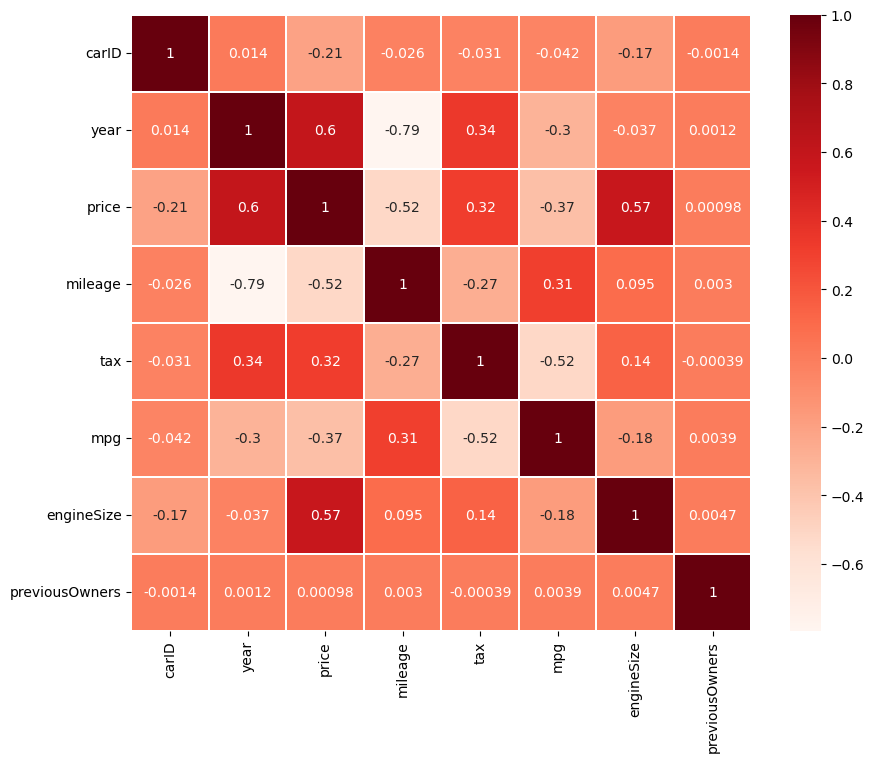

In [23]:
# Remove rows with missing values
temp = train_set.dropna()

# Select numerical columns for correlation analysis
corr_data = temp.select_dtypes(include=["number"])

# Compute the Pearson correlation matrix
correlation_matrix = corr_data.corr(method="spearman")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = plt.cm.Reds, linewidths=0.1)
plt.show()

- year and mileage have a strong relationship
- and so does tax and mpg
- year, mileage and engineSize have a strong correlation with the target
- carID, paintQuality% and previousOwners seem to have little correlation with any variable

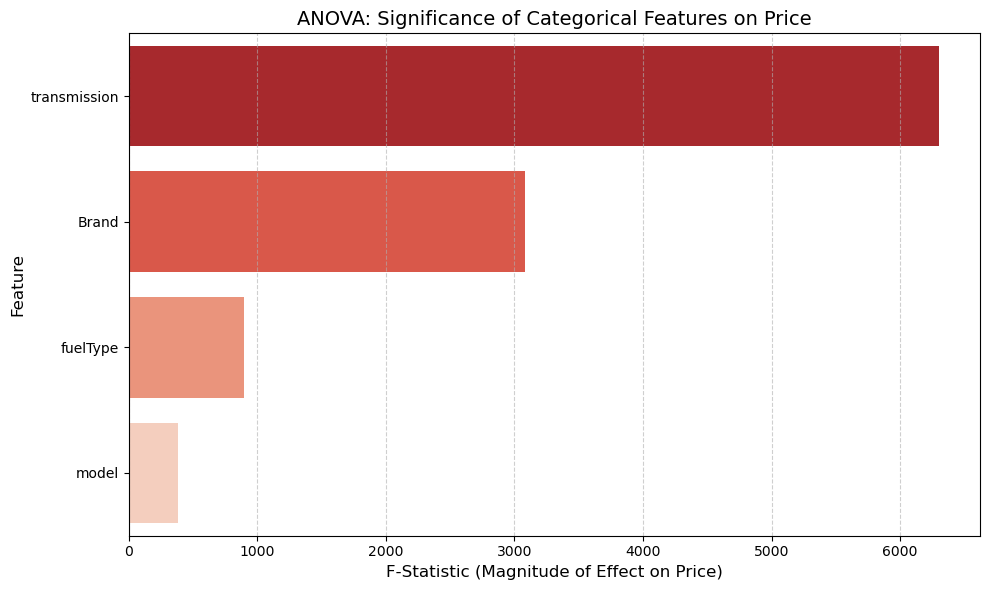

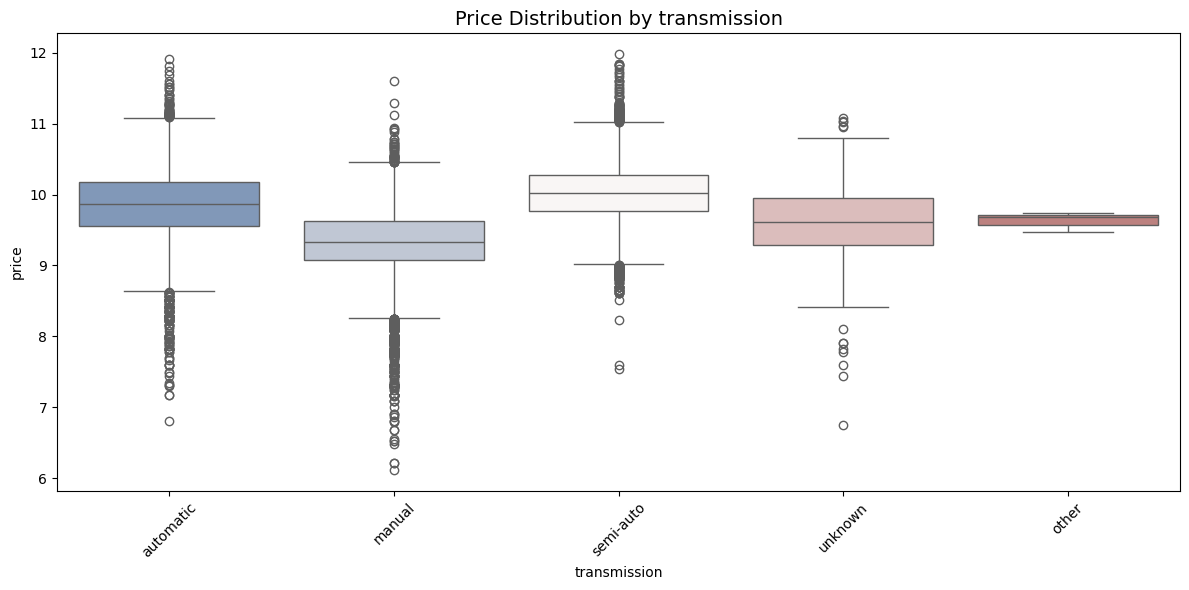

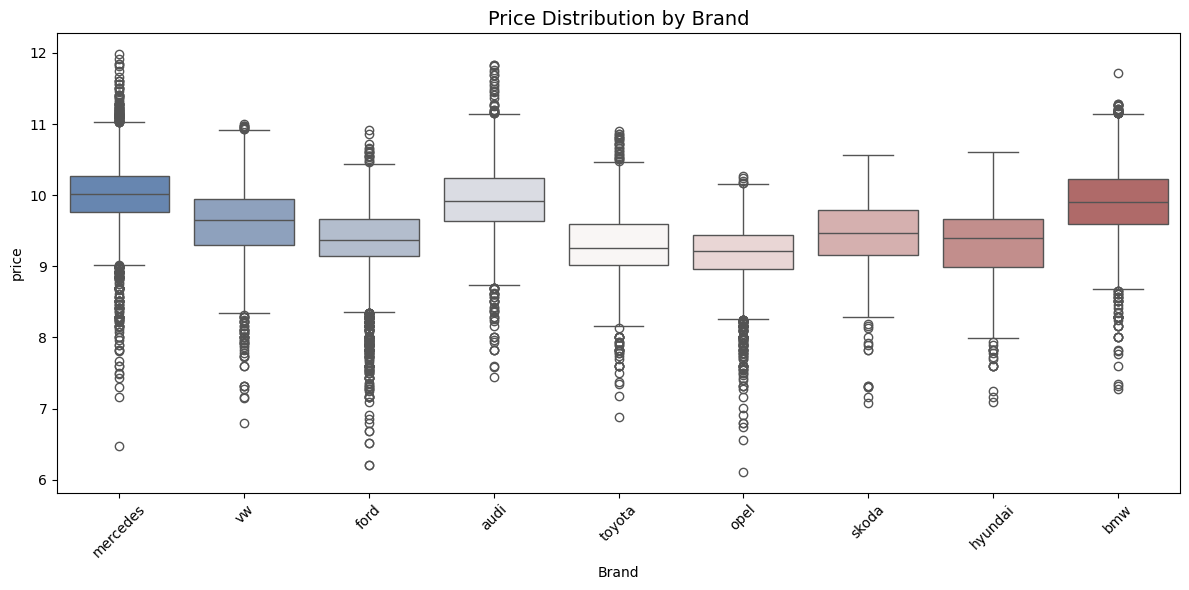

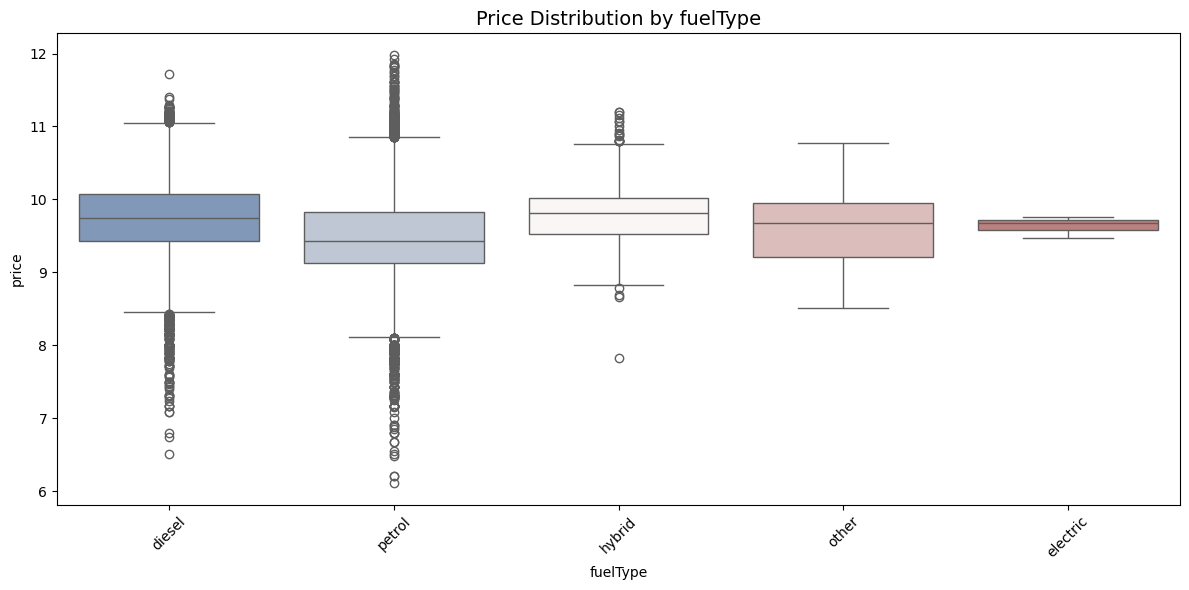

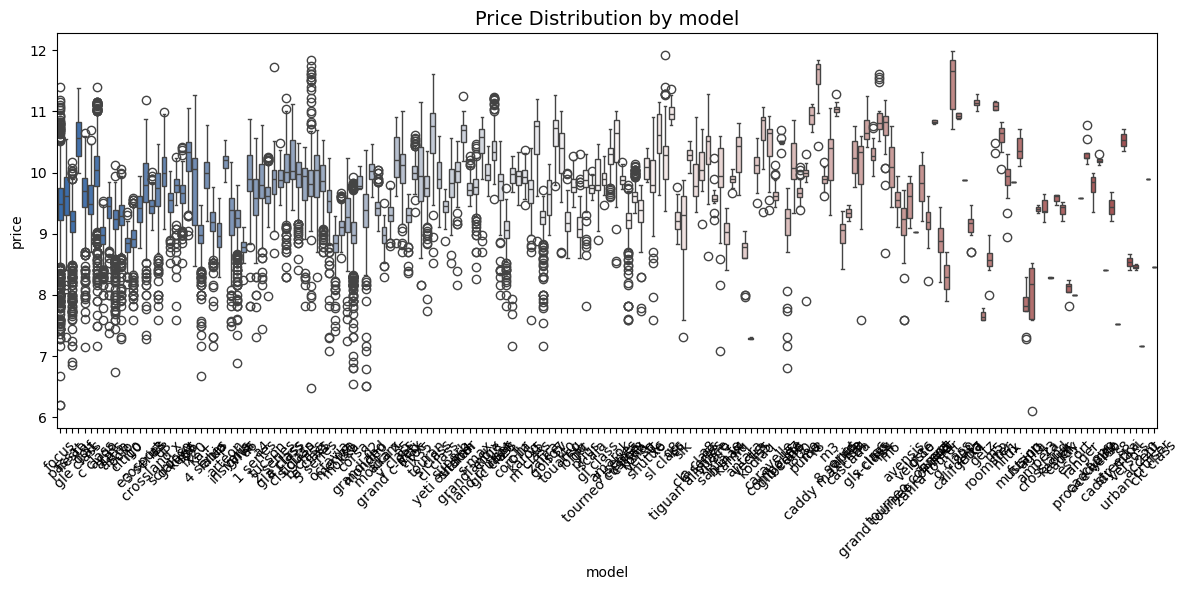

In [ ]:
f_scores = {}
for col in cat_cols:
    # Group price by the categorical levels and drop NaNs
    df_sub = train_set[[col, 'price']].dropna()
    groups = [group['price'].values for name, group in df_sub.groupby(col)]
    
    # perform one-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    f_scores[col] = f_stat

# Convert to a sorted series for plotting
anova_series = pd.Series(f_scores).sort_values(ascending=False)

# Significance Graph
plt.figure(figsize=(10, 6))
sns.barplot(x=anova_series.values, y=anova_series.index, palette='Reds_r')

plt.title('ANOVA: Significance of Categorical Features on Price', fontsize=14)
plt.xlabel('F-Statistic (Magnitude of Effect on Price)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Boxplots for the features 
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_set, x='transmission', y='price', palette='vlag')
plt.title('Price Distribution by transmission', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_set, x='Brand', y='price', palette='vlag')
plt.title('Price Distribution by Brand', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=train_set, x='fuelType', y='price', palette='vlag')
plt.title('Price Distribution by fuelType', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_set, x='model', y='price', palette='vlag')
plt.title('Price Distribution by model', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model has a really low F score

We need to encode categorical variables into numericals. We decided to encode Brand transmission and fuelType with one-hot encoding, and created a Brand_model_encoded where,  we can convert the model column to numeric, by using target encoding, without having to worry about different brands having models with the same name

In [ ]:
# We combine the sets back toghether so we can properly encode them
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)
combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Seperate them again
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()



In [ ]:
# We do this after separating the two sets again, to make sure none of the val_set's data influences the encoding

# Target Encoding 
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Apply that to train
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Same goes for validation
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)



Next we divide our datasets into X(non target columns) and Y(target column) while also removing columns that are irrelevant to the feature selection ("carID","model")

And then we scale our Xs using MinMaxScaler() in order to bring all features into the same range, improving model convergence and ensuring that no single feature dominates due to its scale

We use MinMaxScaler() to avoid having negative values in our scale, so it doesn't interfere with our NN

In [ ]:
drop_cols = ["price", "carID", "model"]

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]


scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

X_train_scaled

,year,mileage,tax,mpg,engineSize,previousOwners,Brand_bmw,Brand_ford,Brand_hyundai,Brand_mercedes,...,Brand_vw,transmission_manual,transmission_other,transmission_semi-auto,transmission_unknown,fuelType_electric,fuelType_hybrid,fuelType_other,fuelType_petrol,Brand_model_encoded
816,0.956522,0.597122,0.783001,0.726479,0.096154,0.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.625663
24543,0.869565,0.765161,0.478341,0.794907,0.076923,0.25,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.458918
37612,0.956522,0.618530,0.783001,0.695326,0.192308,0.00,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.458918
63137,0.826087,0.858642,0.539532,0.976642,0.192308,0.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.625663
63964,1.000000,0.327042,0.783001,0.789973,0.000000,0.00,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.490882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,0.956522,0.626615,0.783001,0.729973,0.384615,1.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.625663
6265,0.956522,0.722312,0.783001,0.682941,0.192308,0.50,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541399
54886,0.826087,0.862369,0.759854,0.785324,0.192308,1.00,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611439
860,0.826087,0.808064,0.478341,0.805195,0.000000,0.75,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.345900


Next we wanted to calculate the optimal number of features using a wrapper method, so we picked RFE (with linear regression) to rank every features importance acording to the model's performance

In [163]:
#no of features
nof_list=np.arange(1,len(X_train_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 22
Score with 22 features: 0.892312


In [164]:
model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 22)

train_set_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)

rfe.support_

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [165]:
X_train_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners',
       'Brand_bmw', 'Brand_ford', 'Brand_hyundai', 'Brand_mercedes',
       'Brand_opel', 'Brand_skoda', 'Brand_toyota', 'Brand_vw',
       'transmission_manual', 'transmission_other', 'transmission_semi-auto',
       'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid',
       'fuelType_other', 'fuelType_petrol', 'Brand_model_encoded'],
      dtype='object')

In [166]:
rfe.ranking_

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [167]:
selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
selected_features

year                       True
mileage                    True
tax                        True
mpg                        True
engineSize                 True
previousOwners            False
Brand_bmw                  True
Brand_ford                 True
Brand_hyundai              True
Brand_mercedes             True
Brand_opel                 True
Brand_skoda                True
Brand_toyota               True
Brand_vw                   True
transmission_manual        True
transmission_other         True
transmission_semi-auto     True
transmission_unknown       True
fuelType_electric          True
fuelType_hybrid            True
fuelType_other             True
fuelType_petrol            True
Brand_model_encoded        True
dtype: bool

The RFE only rejected the previousOwners feature

Next we checked the features's importance with an embeded method, the LASSO, in orther to better and more confidently identify features with minimal predictive contribuition

In [168]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 21 variables and eliminated the other 2 variables


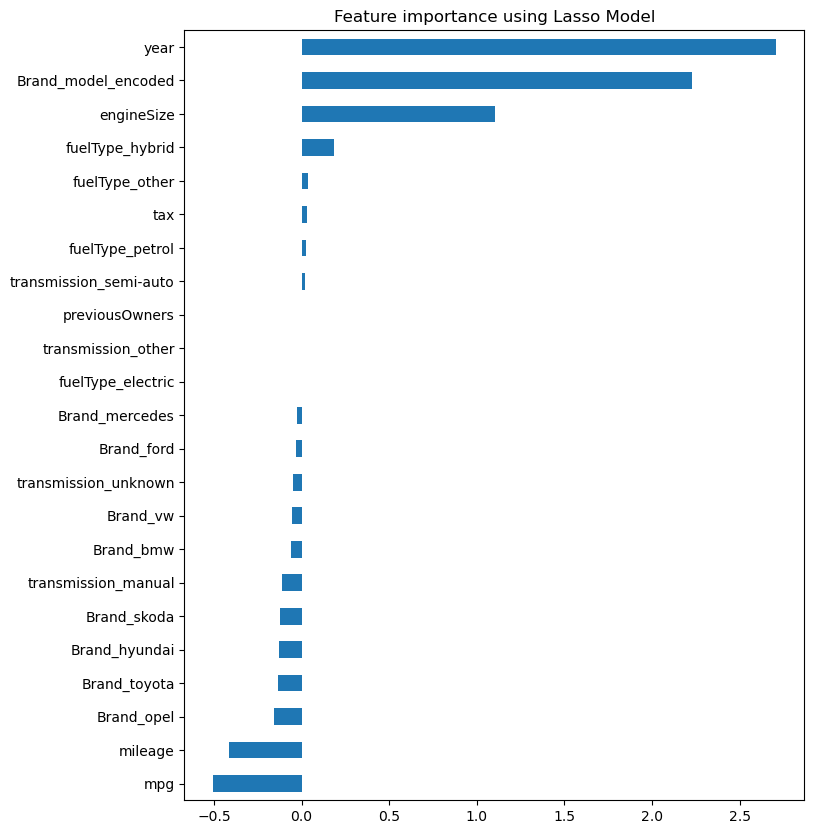

In [169]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | RFE LR| Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |---|
| year | Keep? | Keep | Keep | Include in the model |
| engineSize | Keep | Keep |Keep| Include in the model |
| tax | Keep?| Discard? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard | Discard |
| mpg | Keep? | Keep | Keep? | Try with and without |
| mileage | Keep? | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>



After testing out different combinations, we came to the conclusion that dropping previousOwners had the best result

In [170]:
X_train_scaled = X_train_scaled.drop(columns=['previousOwners'])

X_val_scaled = X_val_scaled.drop(columns=['previousOwners'])